Objetivo:
- leer un resultado estadístico
- ejecutar 2–3 tests básicos
- explicar qué significa el p-value y qué NO significa
- justificar por qué usas un test y no otro

In [17]:
import numpy as np
import pandas as pd
from scipy import stats

np.random.seed(0)

n = 40

df = pd.DataFrame({
    "group": ["control"] * n + ["treated"] * n,
    "value": np.concatenate([
        np.random.normal(loc=10, scale=2, size=n),   # control
        np.random.normal(loc=11, scale=2, size=n),   # treated (ligero efecto)
    ])
})

df.head()


,group,value
0,control,13.528105
1,control,10.800314
2,control,11.957476
3,control,14.481786
4,control,13.735116


In [18]:
control = df[df["group"] == "control"]["value"]
treated = df[df["group"] == "treated"]["value"]

control.describe(), treated.describe()


(count    40.000000
 mean     10.625085
 std       2.155786
 min       4.894020
 25%       9.541111
 50%      10.646742
 75%      12.069297
 max      14.539509
 Name: value, dtype: float64,
 count    40.000000
 mean     10.252746
 std       1.640946
 min       7.547435
 25%       9.203151
 50%      10.160145
 75%      11.282187
 max      14.901551
 Name: value, dtype: float64)

Hipótesis nula y alternativa (aplicado)

H0 
La media de value es la misma en control y treated.

H1
La media de value es distinta.

In [19]:
# t-test (Welch) => Comparar medias sin asumir varianzas iguales.
# En la práctica no sabes si las varianzas son iguales → Welch es más seguro
t_stat, p_value = stats.ttest_ind(treated, control, equal_var=False)

t_stat, p_value

(np.float64(-0.8691947230640317), np.float64(0.387595960253478))

t_stat: tamaño de la diferencia en unidades de error
p_value: qué tan compatible es esta diferencia con H0

t_stat -0.8 => “La diferencia observada es menor que una vez el ruido esperado”. (el signo da igual)
Regla mental útil:

|t| ≈ 0 → diferencia despreciable frente al ruido
|t| ≈ 1 → diferencia del tamaño del ruido
|t| ≥ 2 → diferencia claramente mayor que el ruido

Aquí:
|−0.8| < 1 → la diferencia está dentro del ruido

Si p < 0.05: evidencia contra H0
Si p >= 0.05: no hay evidencia suficiente

p = 0.38 → una diferencia como esta (o mayor) ocurre el 38 % de las veces si H₀ es cierta
Eso es muy compatible con H₀

Conclusion:
No hay evidencia suficiente para rechazar que las medias sean iguales (H0)

In [20]:
# Tamaño de efecto
mean_control = control.mean()
mean_treated = treated.mean()
diff = mean_treated - mean_control

mean_control, mean_treated, diff

(np.float64(10.625084946432349),
 np.float64(10.252745917023612),
 np.float64(-0.372339029408737))

Un tamaño de efecto responde a: ¿Cuán grande es la diferencia en relación a la variabilidad?
Se estandariza:
Cohen’s d / Hedges g → diferencia en desviaciones estándar
Cliff’s delta → probabilidad relativa (no paramétrico)

In [21]:
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    sx, sy = np.var(x, ddof=1), np.var(y, ddof=1)
    sp = np.sqrt(((nx-1)*sx + (ny-1)*sy) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / sp

d = cohens_d(treated, control)
d


np.float64(-0.1943578486455279)

|d| ≈ 0.2 → pequeño
|d| ≈ 0.5 → medio
|d| ≥ 0.8 → grande

La diferencia de medias es −0.37 unidades.
El tamaño de efecto estandarizado (Cohen’s d) es pequeño, lo que indica que la diferencia es reducida en relación a la variabilidad de los datos.
Aunque no se detecta significación estadística (p = 0.38), el efecto observado es además trivial desde el punto de vista práctico.

diff → “cuánto”

t / p → “cuán compatible con H₀”

effect size → “cuán importante es”

In [22]:
# CI = intervalo plausible para el tamaño del efecto/diferencia, dado el muestreo
rng = np.random.default_rng(42)

def bootstrap_ci_diff_means(x, y, n_boot=5000, alpha=0.05):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    boots = np.empty(n_boot)
    for i in range(n_boot):
        xb = rng.choice(x, size=nx, replace=True)
        yb = rng.choice(y, size=ny, replace=True)
        boots[i] = xb.mean() - yb.mean()
    lo = np.quantile(boots, alpha/2)
    hi = np.quantile(boots, 1 - alpha/2)
    return lo, hi

ci_lo, ci_hi = bootstrap_ci_diff_means(treated, control)
diff, (ci_lo, ci_hi)


(np.float64(-0.372339029408737),
 (np.float64(-1.2144471948663083), np.float64(0.46183859771490005)))

Si el CI incluye 0 → compatible con “sin diferencia”
El ancho del CI te dice incertidumbre (n pequeño / var grande ⇒ CI ancho)

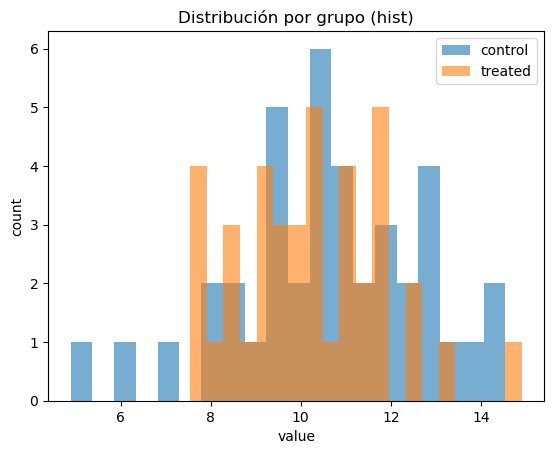

In [23]:
# Suposiciones: normalidad/varianzas/independencia
import matplotlib.pyplot as plt

plt.hist(control, alpha=0.6, bins=20, label="control")
plt.hist(treated, alpha=0.6, bins=20, label="treated")
plt.legend()
plt.title("Distribución por grupo (hist)")
plt.xlabel("value")
plt.ylabel("count")
plt.show()


normalidad aproximada: “parece unimodal / sin colas raras”

independencia: viene del diseño (muestras distintas)

varianzas: Welch ya te protege si difieren

In [24]:
# ¿Y si no hay normalidad? → Mann–Whitney
u_stat, p_u = stats.mannwhitneyu(treated, control, alternative="two-sided")

u_stat, p_u

(np.float64(683.0), np.float64(0.26227859474350024))

distribución “razonable” → t-test

distribución rara / muchos outliers → Mann–Whitney

In [25]:
# Tablas: chi-cuadrado / Fisher
import numpy as np
from scipy import stats

# Ejemplo: "marker_present" por grupo
# filas: group (control/treated), columnas: marker (no/sí)
table = np.array([
    [18,  2],   # control
    [12,  8],   # treated
])

chi2, p_chi2, dof, expected = stats.chi2_contingency(table)
p_fisher = stats.fisher_exact(table)[1]

chi2, p_chi2, expected, p_fisher


(np.float64(3.3333333333333335),
 np.float64(0.06788915486182893),
 array([[15.,  5.],
        [15.,  5.]]),
 np.float64(0.06483316160735517))

si esperados pequeños (≈ <5) → Fisher

si no → chi-cuadrado ok

In [26]:
# Correlación: Pearson vs Spearman
rng = np.random.default_rng(42)

df["age"] = rng.integers(30, 75, size=len(df))
df[["age", "value"]].head()

r_p, p_p = stats.pearsonr(df["age"], df["value"])
r_s, p_s = stats.spearmanr(df["age"], df["value"])

(r_p, p_p), (r_s, p_s)

((np.float64(-0.0841564382018217), np.float64(0.45797255996289055)),
 (np.float64(-0.08965482296644248), np.float64(0.42901930584756975)))

Pearson: relación lineal
Spearman: relación monótona (rangos)
p ≥ 0.05 → no evidencia de asociación

In [27]:
# Ejercicio: 200 genes + FDR (BH)

rng = np.random.default_rng(42)

n_per_group = 30
genes = [f"gene_{i:03d}" for i in range(200)]
groups = np.array(["control"]*n_per_group + ["treated"]*n_per_group)
sample_id = np.array([f"S{i:03d}" for i in range(len(groups))])

# Expresión base
X = rng.normal(loc=10, scale=2, size=(len(groups), len(genes)))

# Introducimos efecto real en 15 genes (treated + 1.0)
effect_genes = set(genes[:15])
for j, g in enumerate(genes):
    if g in effect_genes:
        X[groups == "treated", j] += 1.0

df_long = pd.DataFrame({
    "sample_id": np.repeat(sample_id, len(genes)),
    "group": np.repeat(groups, len(genes)),
    "gene": np.tile(genes, len(sample_id)),
    "expression": X.reshape(-1)
})

df_long.head()


,sample_id,group,gene,expression
0,S000,control,gene_000,10.609434
1,S000,control,gene_001,7.920032
2,S000,control,gene_002,11.500902
3,S000,control,gene_003,11.881129
4,S000,control,gene_004,6.097930


In [28]:
# p-values por gen con Welch
rows = []
for g in genes:
    x = df_long.loc[(df_long["group"]=="treated") & (df_long["gene"]==g), "expression"].values
    y = df_long.loc[(df_long["group"]=="control") & (df_long["gene"]==g), "expression"].values
    t, p = stats.ttest_ind(x, y, equal_var=False)
    rows.append((g, t, p))

res = pd.DataFrame(rows, columns=["gene", "t", "p"])
res.sort_values("p").head(10)


,gene,t,p
12,gene_012,4.045709,0.000161
23,gene_023,3.440571,0.001085
4,gene_004,3.055732,0.003406
0,gene_000,2.985797,0.004151
9,gene_009,2.542487,0.013699
6,gene_006,2.504367,0.015117
144,gene_144,-2.293925,0.025437
32,gene_032,2.246395,0.028586
132,gene_132,-2.219496,0.030427
143,gene_143,2.183713,0.033231


In [29]:
# BH (FDR) manual

def bh_fdr(pvals):
    pvals = np.asarray(pvals)
    m = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = ranked * m / (np.arange(1, m+1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    q = np.clip(q, 0, 1)
    out = np.empty_like(q)
    out[order] = q
    return out

res["q_bh"] = bh_fdr(res["p"].values)
res["signif_0_05"] = res["q_bh"] < 0.05

res.sort_values("q_bh").head(20)


,gene,t,p,q_bh,signif_0_05
12,gene_012,4.045709,0.000161,0.032195,True
23,gene_023,3.440571,0.001085,0.108518,False
4,gene_004,3.055732,0.003406,0.207543,False
0,gene_000,2.985797,0.004151,0.207543,False
132,gene_132,-2.219496,0.030427,0.493636,False
116,gene_116,-2.107596,0.039617,0.493636,False
27,gene_027,-2.120164,0.039459,0.493636,False
80,gene_080,-2.144435,0.036257,0.493636,False
143,gene_143,2.183713,0.033231,0.493636,False
144,gene_144,-2.293925,0.025437,0.493636,False


In [30]:
res["signif_0_05"].sum(), len(effect_genes)

(np.int64(1), 15)

Aplicamos Welch por gen
Corregimos por múltiples comparaciones con BH (FDR 0.05)
Listamos genes significativos
Esto es asociación; no implica causalidad

In [31]:
pd.DataFrame({
    "test": ["Welch t-test", "Mann–Whitney"],
    "p_value": [p_value, p_u]
})

,test,p_value
0,Welch t-test,0.387596
1,Mann–Whitney,0.262279


We compared values between control and treated using a Welch t-test (two-sided). We did not detect a statistically significant difference between groups (p = 0.388). The observed difference is compatible with random variation under the null hypothesis. This analysis does not establish causality.